# Similarity explanations for 20 newsgroups dataset

In this notebook, we apply the similarity explanation method to a feed forward neural network (FFNN) trained on the 20 newsgroups dataset. 

The 20 newsgroups dataset is a corpus of 18846 text documents (emails) divided into 20 sections. The FFNN is trained to classify each document in the correct section. The model uses pre-trained sentence embeddings as input features, which are obtained from raw text using a [pretrained transformer](https://www.sbert.net/docs/pretrained_models.html). 

Given an input document of interest, the similarity explanation method used here aims to find text documents in the training set that are similar to the document of interest according to "how the model sees them", meaning that the similarity metric makes use of the gradients of the model's loss function with respect to the model's parameters.

The similarity explanation tool supports both `pytorch` and `tensorflow` backends. In this example, we will use the `pytorch` backend.

A more detailed description of the method can be found [here](../methods/Similarity.ipynb). The implementation follows  [Charpiat et al., 2019](https://papers.nips.cc/paper/2019/hash/c61f571dbd2fb949d3fe5ae1608dd48b-Abstract.html) and  [Hanawa et al. 2021](https://arxiv.org/abs/2006.04528).

In [2]:
import os
import torch
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from termcolor import colored
from torch.utils.data import DataLoader
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from alibi.explainers.similarity.grad import GradientSimilarity

In [3]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y].astype('float32')

class TorchDataset(torch.utils.data.Dataset):
    """Utility class to create a torch dataloader from numpy arrays.
    """
    def __init__(self, *indexables):
        self.indexables = indexables

    def __getitem__(self, idx):
        output = tuple(indexable[idx] for indexable in self.indexables)
        return output if len(output) > 1 else output[0]

    def __len__(self):
        return len(self.indexables[0])
    
def appendInt(num):
    """Converts integer into cardials (ex. 1 -> 1st, 2 -> 2nd, etc.)
    
    Parameters
    ----------
    num
        Integer number
    
    Returns
    -------
    Oridinal suffixes
    """
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'
    
def break_doc_in_lines(text, nb_words_per_line=18):
    """Breaks document in lines of a fixed number of words for visualization purposes.
    
    Parameters
    ----------
    text
        String to break in line
    nb_words_per_line
        number of words for each line
    
    Returns
    -------
    String with line breakers
    """
    text_l = text.split(' ')
    text_conc = []
    nb_lines = np.floor(len(text_l) / nb_words_per_line).astype(int) + 1
    for i in range(nb_lines):
        tl = text_l[i * nb_words_per_line: (i + 1) * nb_words_per_line]
        text_conc.append(' '.join(tl))
    text = '\n'.join(text_conc)
    
    return text

## Load data

Loading and preparing the 20 newsgroups dataset.

In [4]:
example_idx = 4

print("Loading 20 news groups dataset")
data = fetch_20newsgroups(shuffle=True, random_state=1, subset='all',
                          remove=('headers', 'footers', 'quotes'),
                          return_X_y=False)
X, y = np.asarray(data.data), data.target
target_names = data.target_names
df = pd.DataFrame({'text': X, 'labels': y})

print("Cleaning text")
df['text_cleaned'] = df['text'].str.replace('\s+',' ')
df['text_cleaned'] = df['text_cleaned'].str.strip()
df['text_cleaned'] = df['text_cleaned'].str.slice(0,131072)
df = df.replace('', np.NaN).dropna()
df = df.drop_duplicates(subset='text_cleaned')
print('')

print(colored("Sample document before cleaning", 'red'))
print(f"{df['text'][example_idx]}")
print('')
print(colored("Sample document after cleaning", 'red'))
print(break_doc_in_lines(f"{df['text_cleaned'][example_idx]}"))
print('')

print("Splitting train - test")
df_train, df_test = train_test_split(df, test_size=0.2)
X_train, y_train = df_train['text_cleaned'].values, df_train['labels'].values
X_test, y_test = df_test['text_cleaned'].values, df_test['labels'].values
y_train, y_test = to_categorical(y_train, num_classes=20), to_categorical(y_test, num_classes=20)
print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

Loading 20 news groups dataset
Cleaning text


The default value of regex will change from True to False in a future version.



Sample document before cleaning

So its an automatic? Don't know if US spec=CDN spec. for Maximas.


If it is the first set of brake pads on front, then this is fine. My car
eats a set every 15k miles or so. The fact that he is replacing the
muffler too is also ok.


The mileage is fairly low - but typical fwd stuff is CV joints. Check
the maintenance records with the manufacturers requirements for valve
adjustments, timing belt changes and so on.

The 60k mile service is often expensive, so make sure he has done everything.


Well, this is one of the commonly cited methods for identifying a
car with highway miles. 
Might check the gas pedal wear too. Ask him how many sets of tires he
has been through. A highway car might have squeezed by on 2 sets,
a hard driven car 6-10 sets.



Well, the Maxima should be pretty reliable - but if its out of warranty
you should get it checked out by someone knowledgeable first. Stuff
for Japanese cars can be expensive.


1995 model year, I believe. 


## Define and train model

We define and train a `pytorch` classifier using sentence embeddings as inputs.

### Define model

In [5]:
class EmbeddingModel:
    """Pre-trained sentence transformer wrapper.
    """
    def __init__(
        self,
        model_name: str = 'paraphrase-MiniLM-L6-v2',  # https://www.sbert.net/docs/pretrained_models.html
        max_seq_length: int = 200,
        batch_size: int = 32,
        device: torch.device = None
    ) -> None:
        if not isinstance(device, torch.device):
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encode_text = SentenceTransformer(model_name).to(device)
        self.encode_text.max_seq_length = max_seq_length
        self.batch_size = batch_size
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.encode_text.encode(x, 
                                       convert_to_numpy=True, 
                                       batch_size=self.batch_size,
                                       show_progress_bar=False)

class Classifier(nn.Module):
    """FFNN classifier with pretrained sentence embeddings inputs.
    """
    def __init__(
        self, 
        n_classes= 20
    ) -> None:
        """ Text classification model from sentence embeddings. """
        super().__init__()
        self.head = nn.Sequential(nn.Linear(384, 256), 
                                  nn.LeakyReLU(.1), 
                                  nn.Dropout(.5), 
                                  nn.Linear(256, n_classes))
        
    def forward(self, sentence_embeddings) -> torch.Tensor:
        return self.head(sentence_embeddings)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

### Get sentence embeddings and define dataloaders

In [7]:
embedding_model = EmbeddingModel(device=device)

print('Getting train embeddings')    
embeddings_train = embedding_model(X_train)
train_loader = DataLoader(TorchDataset(torch.Tensor(embeddings_train).to(device), 
                                       torch.Tensor(y_train).to(device)), 
                          batch_size=32, 
                          shuffle=True)

print('Getting test embeddings')  
embeddings_test = embedding_model(X_test)
test_loader = DataLoader(TorchDataset(torch.Tensor(embeddings_test).to(device), 
                                      torch.Tensor(y_test).to(device)), 
                         batch_size=32, 
                         shuffle=False)

Getting train embeddings
Getting test embeddings


### Train model

In [19]:
epochs = 3

# initialize classifier
model = Classifier().to(device)
print('Training classifier')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(epochs):
    for x, y in tqdm(train_loader):
        y_hat = model(x)
        optimizer.zero_grad()
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()

Training classifier


100%|███████████████| 457/457 [00:00<00:00, 1142.23it/s]


### Evaluate model

Evaluating the model on train and test set. Since the dataset is well balanced, we only consider accuracy as evaluation metric.

In [20]:
def eval_model(model, loader):
    model.eval()
    logits, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            y_hat = model(x)
            logits += [y_hat.cpu().numpy()]
            labels += [y.cpu().numpy()]
    logits = np.concatenate(logits, 0)
    preds = np.argmax(logits, 1)
    labels = np.concatenate(labels, 0)
    accuracy = (preds == labels.argmax(axis=1)).mean()
    print(f'Accuracy: {accuracy:.3f}')
    
print('Train set evaluation')
eval_model(model, train_loader)
print('Test set evaluation')
eval_model(model, test_loader)

Train set evaluation
Accuracy: 0.716
Test set evaluation
Accuracy: 0.661


## Find similaraties 

Selecting a reference set of 1000 random samples from the training set. The `GradientSimilarity` explainer will find the most similar instances among those. This downsampling step is performed in order to speed up the `fit` step.

In [21]:
idxs_ref = np.random.choice(len(X_train), 1000, replace=False)
X_ref = X_train[idxs_ref]
embeddings_ref = embeddings_train[idxs_ref]
y_ref = y_train[idxs_ref]

Initializing a `GradientSimilarity` explainer instance.

In [22]:
gsm = GradientSimilarity(model, 
                         loss_fn, 
                         precompute_grads=True, 
                         sim_fn='grad_cos', 
                         backend='pytorch', 
                         device=device)

Fitting the explainer on the reference data.

In [23]:
gsm.fit(embeddings_ref, y_ref)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'pytorch',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random instances from the test set.

In [24]:
idxs_samples = np.random.choice(len(X_test), 5, replace=False)
X_sample, embeddings_sample, y_sample = X_test[idxs_samples], embeddings_test[idxs_samples], y_test[idxs_samples]

Getting predictions and explanations for each of the 5 test samples.

In [25]:
preds = model(torch.Tensor(embeddings_sample).to(device)).detach().cpu().numpy().argmax(axis=1)
expls = gsm.explain(embeddings_sample, y_sample)

## Visualizations 

Building a dictionary for each sample for visualization purposes. 
Each dictionary contains:
* The original text document `x` (not the embedding representation).
* The corresponding label `y`.
* The corresponding model's prediction `pred`.
* The reference instances ordered by similarity `x_sim`.
* The corresponding reference labels ordered by similarity `y_sim`.
* The corresponding model's predictions for the reference set `preds_sim`.

In [26]:
ds = []
for j in range(len(embeddings_sample)):
    y_sim = y_ref[expls.data['ordered_indices'][j]].argmax(axis=1)
    X_sim = X_ref[expls.data['ordered_indices'][j]]
    sim_embedding = embeddings_ref[expls.data['ordered_indices'][j]]
    preds_sim = model(torch.Tensor(sim_embedding).to(device)).detach().cpu().numpy().argmax(axis=1)

    d = {'x': X_sample[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j],
         'x_sim': X_sim,
         'y_sim': y_sim, 
         'preds_sim': preds_sim}
    ds.append(d)

### Most similar instances

Showing the 3 most similar instances for each of the test instances.

In [27]:
for sample_nb in range(5):
    title = f"Sample nb {sample_nb}"
    print(colored(title, 'blue'))
    print(colored(f"{len(title) * '='}", 'blue'))
    print('')
    
    print(colored("Original instance - ", 'red'), 
          colored(f"Label: {target_names[ds[sample_nb]['y']]} - ", 'red'), 
          colored(f"Prediction: {target_names[ds[sample_nb]['pred']]}", 'red'))
    print(break_doc_in_lines(f"{ds[sample_nb]['x']}"))
    print('')
    
    for i in range(3):
        print(colored(f"{i+1}{appendInt(i+1)} most similar instance - ", 'red'), 
              colored(f"Label: {target_names[ds[sample_nb]['y_sim'][i]]} - ", 'red'), 
              colored(f"Prediction: {target_names[ds[sample_nb]['preds_sim'][i]]}", 'red'))
        print(break_doc_in_lines(f"{ds[sample_nb]['x_sim'][i]}"))
        print('')

Sample nb 0

Original instance -  Label: rec.sport.baseball -  Prediction: rec.sport.baseball
There are several reasons for this difference. The main reason is that good hitters in their prime (such
as Frank Thomas and Danny Tartabull) are rarely regular DH's, even if they can't field; it's more commonly
a place to put aging veterans. Another use of the DH slot is to help a player come
back from injury slowly, getting his bat in the lineup without forcing him to play in the field.
I would expect such players to hit worse as DH's than they did during the rest of the
season. A third factor is that most player who split time between DH and first or the outfield
don't hit as well as DH's for some reason. Reggie Jackson was a good example; in five years
as a RF/DH for the Angels, he hit like the old Reggie when he was in right. The
second and third factors will be lost if players are considered by their primary position only; a player
who plays 90 games in right and 60 at DH will count only

### Most similar labels distributions 

Showing the average similarity scores for each group of instances in the reference set belonging to the same true class and to the same predicted class. 

In [28]:
def plot_distributions(ds, expls, target_names, figsize=(20, 5)):

    for i in range(len(ds)):
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=False)
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 
                                       'scores': expls.data['scores'][i]})
        title = f"Sample nb {i}"
        print(colored(title, 'blue'))
        print(colored(f"{len(title) * '='}", 'blue'))
        print('')

        print(colored("Original instance", 'red'))
        print(colored(f"Label: section {d['y']}, {target_names[d['y']]}", 'red')) 
        print(colored(f"Prediction: section {d['pred']}, {target_names[d['pred']]}", 'red'))
        print(break_doc_in_lines(f"{d['x']}"))
        
        df_y = df_ditribution.groupby('y_sim')['scores'].mean()
        df_y.index = target_names
        df_y.sort_values(ascending=True).plot(kind='barh', ax=axes[0])
        axes[0].set_title("Averaged scores for each true class in reference set \n")
        
        df_preds = df_ditribution.groupby('preds_sim')['scores'].mean()
        df_preds.index = target_names
        df_preds.sort_values(ascending=True).plot(kind='barh', ax=axes[1])
        axes[1].set_title("Averaged scores for each predicted class in reference set \n")
        fig.tight_layout()
        plt.show()

Sample nb 0

Original instance
Label: section 9, rec.sport.baseball
Prediction: section 9, rec.sport.baseball
There are several reasons for this difference. The main reason is that good hitters in their prime (such
as Frank Thomas and Danny Tartabull) are rarely regular DH's, even if they can't field; it's more commonly
a place to put aging veterans. Another use of the DH slot is to help a player come
back from injury slowly, getting his bat in the lineup without forcing him to play in the field.
I would expect such players to hit worse as DH's than they did during the rest of the
season. A third factor is that most player who split time between DH and first or the outfield
don't hit as well as DH's for some reason. Reggie Jackson was a good example; in five years
as a RF/DH for the Angels, he hit like the old Reggie when he was in right. The
second and third factors will be lost if players are considered by their primary position only; a player
who plays 90 games in right and 60 at DH

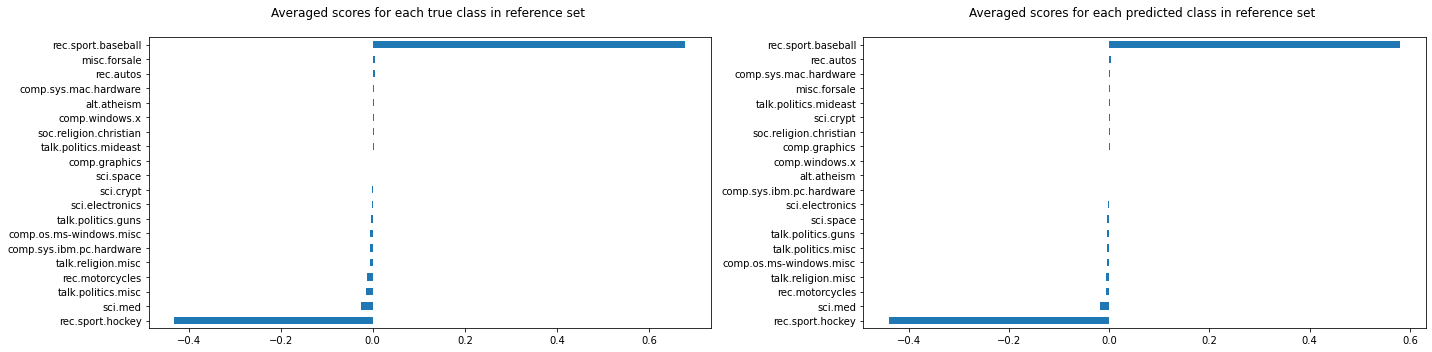

Sample nb 1

Original instance
Label: section 19, talk.religion.misc
Prediction: section 15, soc.religion.christian
I found this on the net at my college. It sounds pretty good to me. What do you
folks think? >This are the tenets of Stan as handed down and set within the Holy Book >of
Stan. > >1: Thou shalt not spill thine drinks or waste thine food, for all that >is is
sacred, and to waste is the denizen of Luc, the Infidel. All who >waste today shall have not
tomorrow. > >2: Thou shalt pay heed to those who know the higher calling of Stan so >that
they may teach you the way, and that thou shalt become one with >Stan and the universe shall
be in your hands. > >3: Thou shalt honor thy loved ones and cherish those near you, for
they >are the true path to happiness, and happiness is a devine gift of thy >lord Stan. >
>4: Stan is the one true God and shall be taken before all others so >that the false
gods will know that he is the one, and all who oppose >him shall forever be banished to


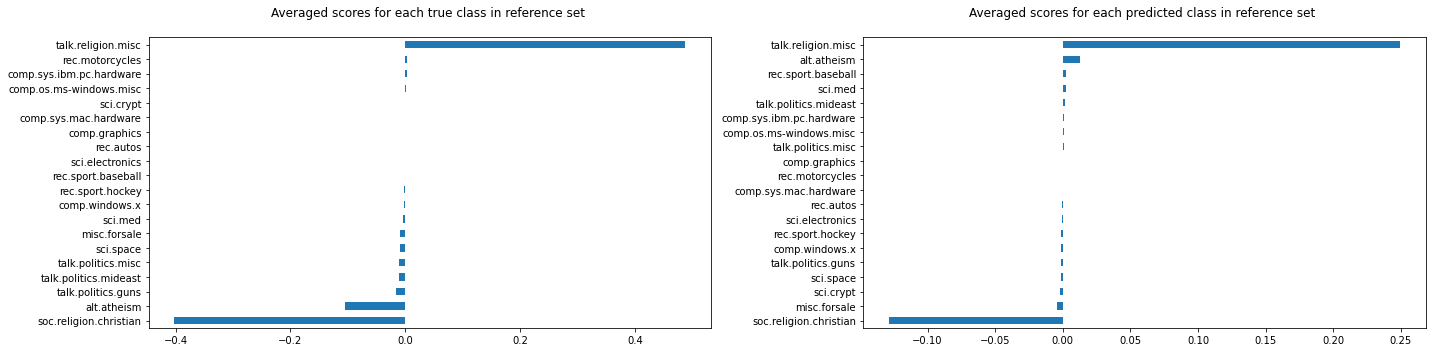

Sample nb 2

Original instance
Label: section 14, sci.space
Prediction: section 14, sci.space
Unfortunately, if you launch this from the US (or are a US citizen), you will need a launch
permit from the Office of Commercial Space Transportation, and I think it may be difficult to get a
permit for an antisatellite weapon... :-) The threshold at which OCST licensing kicks in is roughly 100km. (The
rules are actually phrased in more complex ways, but that is the result.)


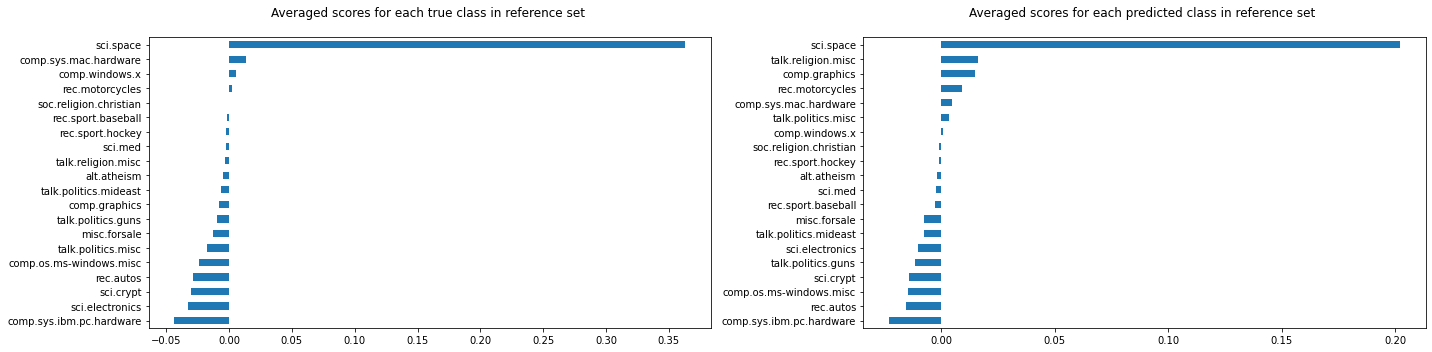

Sample nb 3

Original instance
Label: section 16, talk.politics.guns
Prediction: section 16, talk.politics.guns
Paul Prescod pontificating: PP>> Libertarians oppose BOTH waiting periods AND background checks PP>>-- or ANY prerequisite for exercising
rights that are supposed to PP>>be guaranteed. PP>Let me get this straight. Unlike the other idiots in this
newsgroup, PP>you actually support anybody having unlimited access to guns, PP>inclucing criminals. (or would you prohibit them from
owning them, PP>but not from buying them?) PP>You are a supreme idiot. You make the other idiots look
like Mensa members. Thanks Paul, for yet another fine example of the holier than thou gun control mindset.
Why don't you add something intelligent to the debate, like maybe nyah nyah nyah nyah nyah. --- .
OLX 2.2 . Fight crime..... shoot back!


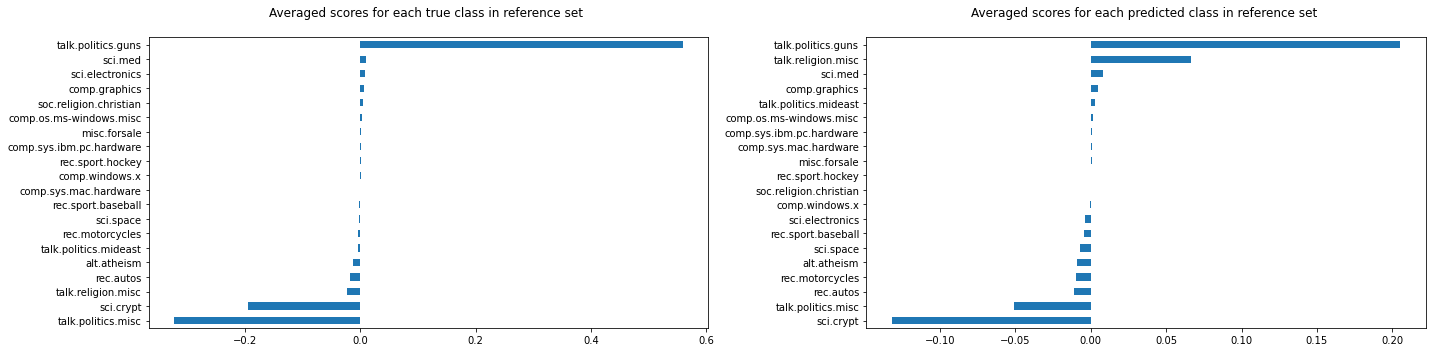

Sample nb 4

Original instance
Label: section 1, comp.graphics
Prediction: section 1, comp.graphics
============================================================================== Please bear with me as i am new at this game, i apologize unreservedly if i hav
e posted another message earlier by mistake. but i digress, could anyone out th ere please explain exactly
what DMORF does (dtax.exe). Does it simply fade one bitmap into another or does it reshape one bitmap
into another. Excuse my ignor ance.....


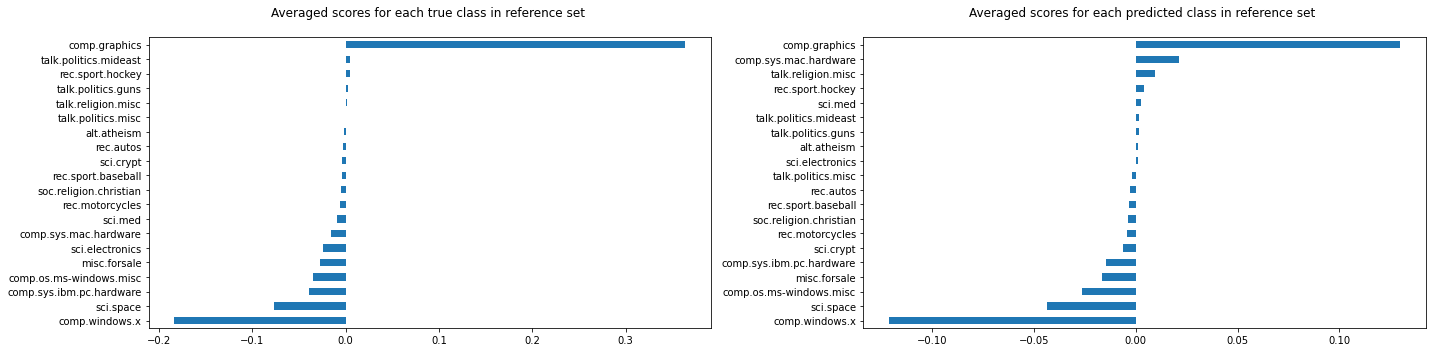

In [29]:
plot_distributions(ds, expls, target_names)